# Modèle SR-LASSO linéaire (fonction de coût square-root $\ell_2$ et pénalité $\ell_1$)

In [21]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

## Théorie

### Fondamentaux

On résout ce problème de minimisation :

$$ \boxed{\min_{\beta\in\mathbb{R}^p}\|y-X\beta\|_2+\lambda\|\beta\|_1}$$

avec une pénalité $\|\beta\|_1=\sum_{j=1}^p|\beta_j|$

### Choix du $\lambda$

#### Trouver $\lambda_0(\cdot)$

##### **Square-root LASSO :** ($\xi = \beta$)

On cherche pour quel $\lambda$ la solution du problème  
$$
\hat{\beta}_\lambda(y) = \arg\min_{\beta} \|y - X\beta\|_2 + \lambda\|\beta\|_1
$$
devient nulle.

On note $r = y - X\beta$. La fonction $\beta \mapsto \|r\|_2$ n'est pas différentiable partout (au point $r = 0$), mais elle est sub-différentiable sur $\mathbb{R}^n \setminus \{0\}$.

On considère la sous-différentielle du critère au point $\beta = 0$ :
$$
\partial \left( \|y - X\beta\|_2 + \lambda \|\beta\|_1 \right) \quad \text{au point } \beta = 0
$$

Comme $\beta = 0$, on a $r = y$, donc :
$$
\partial \left( \|y - X\beta\|_2 \right) = -\frac{X^\top y}{\|y\|_2} \quad \text{(valide si } y \neq 0\text{)}
$$

Et comme précédemment :
$$
\partial \|\beta\|_1 = \{v \in \mathbb{R}^p : v_j \in [-1, 1] \text{ pour tout } j\} \quad \text{au point } \beta = 0
$$

Pour que $\beta = 0$ soit une solution (minimum), il faut :
$$
0 \in -\frac{X^\top y}{\|y\|_2} + \lambda \cdot \partial \|\beta\|_1
$$
soit :
$$
\frac{X^\top y}{\|y\|_2} \in \lambda \cdot \partial \|\beta\|_1
$$

Donc chaque composante de $\frac{X^\top y}{\|y\|_2}$ doit être dans $[-\lambda, \lambda]$ :
$$
\left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty \leq \lambda
$$

Ce qui donne :
$$
\lambda_0(y) = \left\| \frac{X^\top y}{\|y\|_2} \right\|_\infty
$$

Cette forme a l'avantage d'être **pivotal**, c'est-à-dire que $\lambda_0(y)$ **ne dépend pas** du bruit $\sigma$, contrairement au LASSO classique.

#### Algorithme

$$
\boxed{
\begin{array}{ll}
\textbf{QUT Simulation Algorithm (square-root LASSO)} \\
\\
\textbf{Step 0.} & \text{Fixer } M \in \mathbb{N} \text{ (nombre de simulations), } \alpha \in (0, 1). \\
& \text{Initialiser un vecteur } \Lambda \leftarrow \emptyset. \\
\\
\textbf{Step m.} & \text{Pour } m = 1 \text{ à } M : \\
& \quad \text{Simuler } Y_{\text{Sim}}^{(m)} \sim \mathcal{N}(0, I_n). \\
& \quad \text{Calculer } \lambda_0^{(m)} \leftarrow \left\| \frac{X^\top Y_{\text{Sim}}^{(m)}}{\|Y_{\text{Sim}}^{(m)}\|_2} \right\|_\infty. \\
& \quad \text{Ajouter } \lambda_0^{(m)} \text{ à } \Lambda. \\
\\
\textbf{Final Step.} & \text{Définir le seuil } \lambda^{\text{QUT}} \leftarrow \text{quantile}_{1 - \alpha}(\Lambda).
\end{array}
}
$$


#### Test

In [22]:
import numpy as np
from linear_tools import ista, qut_square_root_lasso, generate_data

M, N_matrices = 1000, 20
n, p = 100, 200
alpha, sigma = 0.05, 0.1
alpha_hats = []

def grad_f(beta, y, X):
    r = y - X @ beta
    norm_r = np.linalg.norm(r)
    if norm_r == 0:
        return np.zeros_like(beta)
    return -X.T @ r / norm_r

def prox_g(beta, lmbda, L):
    return np.sign(beta) * np.maximum(np.abs(beta) - lmbda / L, 0.0)

for i in range(N_matrices):

    _, X, _ = generate_data(n, p, s=0, sigma=0, seed=i)

    lambda_qut = qut_square_root_lasso(X, M=M, alpha=alpha, seed=i)

    L = np.linalg.norm(X, ord=2) ** 2  # Lipschitz constant for sqrt-Lasso

    rng = np.random.default_rng(42 + i)
    non_zero_count = 0
    for _ in range(M):
        y = rng.normal(0, sigma, n)
        beta_hat = ista(
            grad_f=grad_f,
            prox_g=prox_g,
            x0=np.zeros(p),
            L=L,
            grad_f_args=(y, X),
            prox_g_args=(lambda_qut, L),
            max_iter=1000,
            tol=1e-6
        )
        if np.any(beta_hat != 0):
            non_zero_count += 1

    alpha_hat = non_zero_count / M
    alpha_hats.append(alpha_hat)

print(f"\t→ Moyenne de alpha_hat : {np.mean(alpha_hats):.4f} ± {np.std(alpha_hats):.4f} (attendu ≈ {alpha})")

	→ Moyenne de alpha_hat : 0.0502 ± 0.0124 (attendu ≈ 0.05)


### Optimisation (ISTA avec backtracking)

#### Formulation

On se ramène à un problème à résoudre de cette forme :  
$$\min_{\beta\in\mathbb{R}^p} F(\beta) := f(\beta) + g(\beta)$$

avec

- $f(\beta) = \|y - X\beta\|_2$

- $g(\beta) = \lambda \|\beta\|_1$ 

#### Calcul de $\nabla f$

On considère $f(\beta) = \|y - X\beta\|_2 = \|r\|_2$. Avec $r = y - X\beta$ le vecteur des résidus.

$$\nabla f(\beta) = \nabla \|r\|_2$$
$$ = \nabla \left( \|r\|_2 \right) = \frac{1}{\|r\|_2} \cdot \nabla \left( \|r\|_2^2 \right)^{1/2}$$
$$ = \frac{1}{\|r\|_2} \cdot \nabla \left( r^\top r \right)^{1/2}$$
$$ = \frac{1}{\|r\|_2} \cdot \frac{1}{2} \cdot \left( r^\top r \right)^{-1/2} \cdot \nabla (r^\top r)$$
$$ = \frac{1}{\|r\|_2} \cdot \nabla (r^\top r)$$

Or, $r = y - X\beta \Rightarrow \nabla (r^\top r) = -2 X^\top r$

Donc, 
$$\boxed{ \nabla f(\beta) = - \frac{X^\top (y - X\beta)}{\|y - X\beta\|_2} }$$

#### Proximal

Comme on reste sur une pénalité $\ell_1$ le proximal est le même que pour le modèle LASSO.

Le proximal du terme de pénalisation $\ell_1$ avec un pas $\gamma = 1/L$ s'écrit :

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \arg\min_{x \in \mathbb{R}^p} \left\{ \frac{L}{2} \|x - z\|_2^2 + \lambda \|x\|_1 \right\}
$$

Ce proximal correspond toujours à l'opérateur de seuillage doux:

$$
\text{prox}_{\frac{\lambda}{L} \|\cdot\|_1}(z) = \operatorname{sign}(z) \odot \max\left(|z| - \frac{\lambda}{L},\, 0\right)
$$

où $\odot$ désigne le produit terme à terme (Hadamard) entre les vecteurs.

## Simulations

In [28]:
n = 70
p = 250
list_s = range(0, 31)

sigma = 1

simu_iter=25
qut_iter=1000
max_iter=10000
tol=1e-8

seed=43

### Square-Root LASSO avec ISTA backtracking

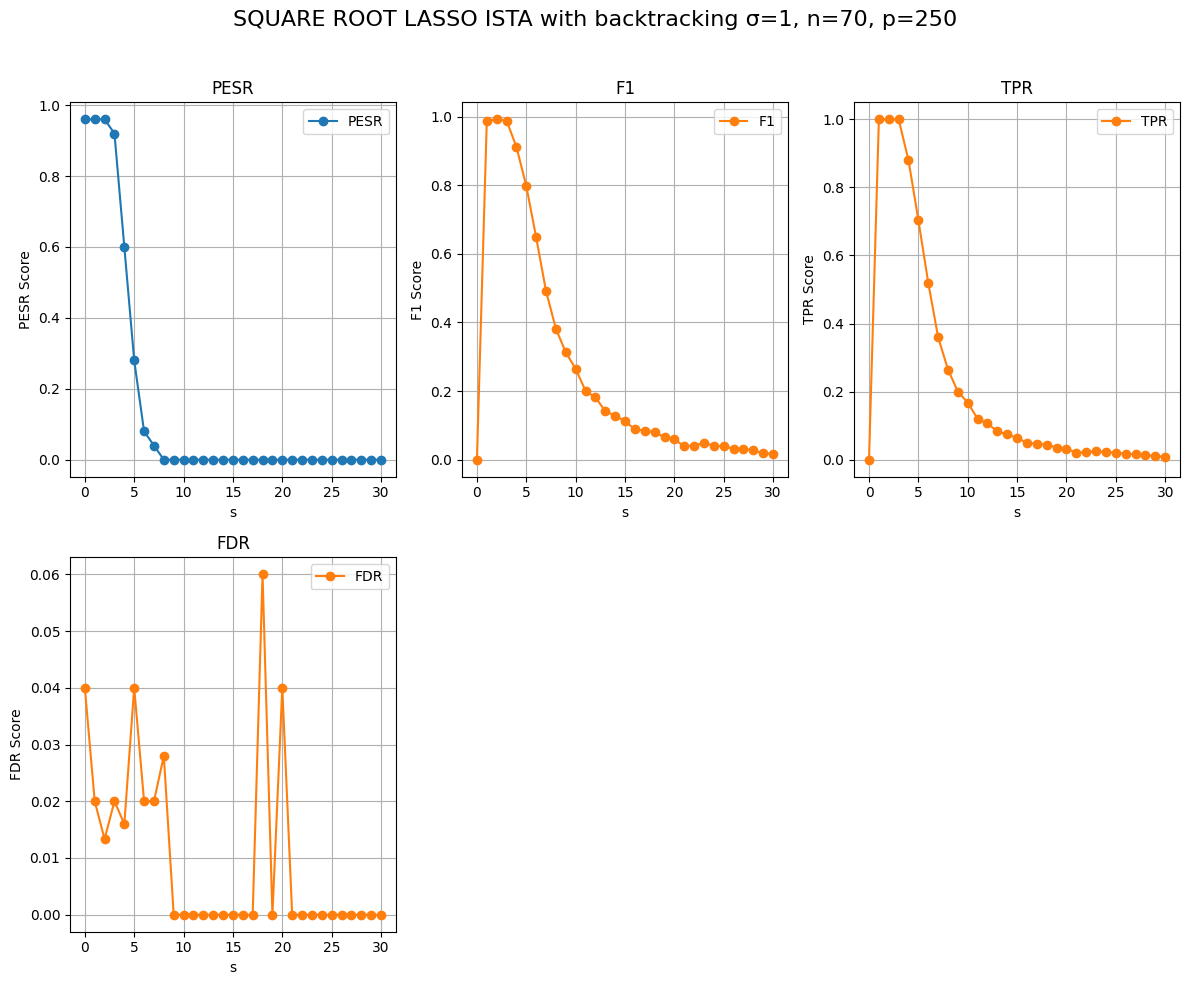

In [30]:
from simulations import SimulationSquareRootLassoIstaBacktracking

Sim = SimulationSquareRootLassoIstaBacktracking(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim.L0 = 1

Sim.run()

Sim.plot()